<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/GAN/cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN
### Ustawienie parametrów pod dane wejściowe

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Dane wejściowe

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                               with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['trainA'], dataset['trainB']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/0.1.0. Subsequent calls will reuse this data.


In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  
  return cropped_image

# normalizacja obrazów z [0, 255] do [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # przewymiarowanie do 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  # losowe przycięcie do 256 x 256 x 3
  image = random_crop(image)

  # losowe odbicie lustrzane
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  return image

In [0]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [0]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

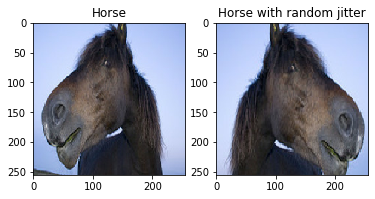

In [11]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0] * 0.5 + 0.5))

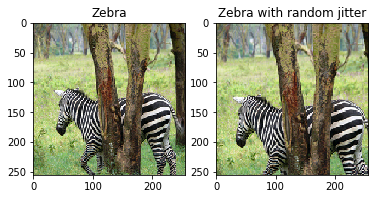

In [12]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0] * 0.5 + 0.5))

### Import i ponowne użycie modeli Pix2Pix

In [0]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

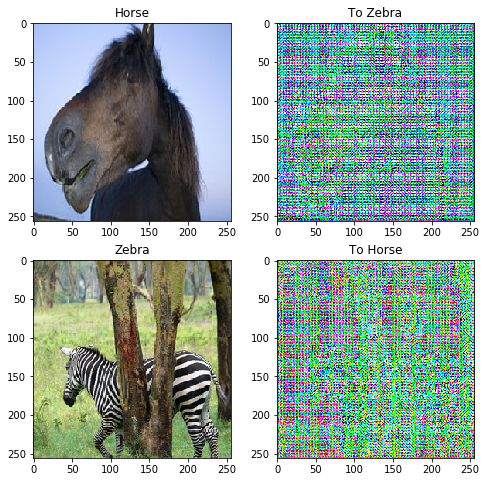

In [14]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

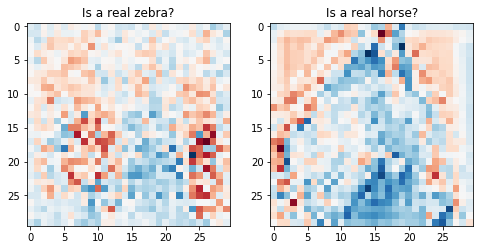

In [15]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Funkcje straty

In [0]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA + loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 + loss

Inicjalizacja optymalizatorów dla wszystkich generatorów i dyskryminatorów.

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Punkty kluczowe

In [0]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# jeśli checkpoint istnieje, przywraca ostatni checkpoint
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Ostatni checkpoint przywrócony!!')

### Trening

In [0]:
EPOCHS = 40

In [0]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # otrzymujemy wartości pikseli między [0, 1], żeby to narysować
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Chociaż wygląda skomplikowanie, pętla treningowa zawiera cztery podstawowe kroki:

*   otrzymanie predykcji
*   obliczenie straty
*   obliczenie gradientów z użyciem backpropagation
*   zastosowanie gradientów do optymalizatora






In [0]:
@tf.function
def train_step(real_x, real_y):
  # persistent jest ustawiony na True, ponieważ tape jest użyty więcej niż raz
  # do obliczenia gradientów
  with tf.GradientTape(persistent=True) as tape:
    # generator G przekłada X -> Y
    # generator F przekłada Y -> X

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)
    
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(fake_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # oblicznie straty
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # całkowita strata generatora
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # obliczanie gradientów dla generatora i dyskryminatora
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)
  
  # zastosowanie gradientów do optymalizatora
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))
  
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

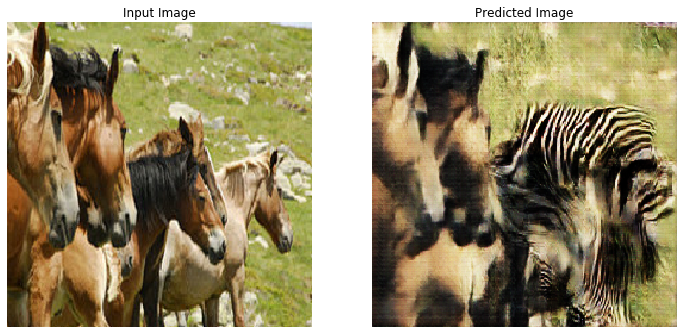

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-8
Time taken for epoch 40 is 259.1805930137634 sec



In [28]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print('.', end='')
    n += 1

  clear_output(wait=True)

  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

### Generowanie z użyciem zestawu danych

In [0]:
# uruchom przetrenowany model na zbiorze testowym
for inp in test_horses.take(5):
  generate_images(generator_g, inp)